In [3]:
import random
import gym
import time
import logging
import gym_minigrid
import numpy as np
import mxnet as mx
import matplotlib.pyplot as plt
from mxnet import nd, autograd
from mxnet import gluon
from IPython import display
from memory import Memory
from utils import preprocess
from model.simple_stack import SimpleStack

/home/seventheli/anaconda/lib/python3.8/site-packages/gluoncv/__init__.py:40: UserWarning: Both `mxnet==1.8.0` and `torch==1.10.2+cu102` are installed. You might encounter increased GPU memory footprint if both framework are used at the same time.
  warnings.warn(f'Both `mxnet=={mx.__version__}` and `torch=={torch.__version__}` are installed. '


### Summary of the algorithm
#### Update Network
* Draw batches of tuples from the replay buffer: $(\phi,r,a,\phi')$.
* Define the following loss
$$\Large(\small Q(\phi,a,\theta)-r-Q(\phi',argmax_{a'}Q(\phi',a',\theta),\theta^-)\Large)^2$$
* Where $\theta^-$ is the parameter of the target network.( Set $Q(\phi',a',\theta^-)$ to zero if $\phi$ is the preprocessed termination state). 
* Update the $\theta$
* Update the $\theta^-$ once in a while








## Set the hyper-parameters

In [4]:
# frame channel
channel = 1
# The size of the batch to learn the Q-function
batch_size = 8
# Resize the raw input frame to square frame of size 80 by 80
image_size = 84
# Skip 4-1 raw frames between steps
skip_frame = 1
# The size of replay buffer; set it to size of your memory (.5M for 50G available memory)
replay_buffer_size = 20000
# With Freq of 1/4-step update the Q-network
learning_frequency = 4
# Each state is formed as a concatenation 4 step frames [f(t-12),f(t-8),f(t-4),f(t)]
frame_len = 32
# Update the target network each 10000 steps
target_update = 10000
# Minimum level of stochasticity of policy (epsilon)-greedy
epsilon_min = 0.01
# The number of step it take to linearly anneal the epsilon to it min value
annealing_end = 1000000.
# The discount factor
gamma = 0.99
# Start to back propagated through the network, learning starts
replay_start_size = 50000
# Run uniform policy for first 30 times step of the beginning of the game
no_op_max = 8
# Number episode to run the algorithm
num_episode = 10000000
max_frame = 200000000
# RMSprop learning rate
lr = 0.00025
# RMSprop gamma1
gamma1 = 0.95
# RMSprop gamma2
gamma2 = 0.95
# RMSprop epsilon bias
rms_eps = 0.01
# Enables gpu if available, if not, set it to mx.cpu()
ctx = mx.gpu()

In [5]:
env_name = 'MiniGrid-Empty-Random-6x6-v0'
env = gym.make(env_name)
num_action = 3
manualSeed = 1
mx.random.seed(manualSeed)
env_name = env_name + "-Map"

In [6]:
dqn = SimpleStack(num_action, frame_len, channel=channel)
dqn.collect_params().initialize(mx.init.Normal(0.02), ctx=ctx)
trainer = gluon.Trainer(dqn.collect_params(), 'RMSProp',
                        {'learning_rate': lr, 'gamma1': gamma1, 'gamma2': gamma2, 'epsilon': rms_eps, 'centered': True})
dqn.collect_params().zero_grad()

In [7]:
target_dqn = SimpleStack(num_action, frame_len, channel=channel)
target_dqn.collect_params().initialize(mx.init.Normal(0.02), ctx=ctx)

In [10]:
loss_f = mx.gluon.loss.L2Loss(batch_axis=0)
# Counts the number of steps so far
frame_counter = 0.
# Counts the number of annealing steps
annealing_count = 0.
# Counts the number episodes so far
epis_count = 0.
# Initialize the replay buffer
replay_memory = Memory(replay_buffer_size, frame_len, channel)
tot_clipped_reward = []
tot_reward = []
frame_count_record = []
t_record = []
moving_average_clipped = 0.
moving_average = 0.

### Train the model

In [11]:
def rew_clipper(row, history):
    counter = 0
    _ = list(reversed(history))[0]
    for i in list(reversed(history))[1:]:
        if i == _:
            counter += 1
        else:
            break
    return (row- 0.0001 * counter) * 100

def render_image(frame, render):
    if render:
        plt.imshow(frame)
        plt.show()
        display.clear_output(wait=True)
        time.sleep(.1)

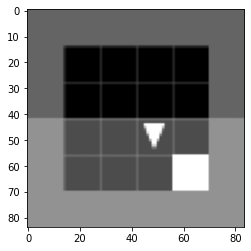

In [14]:
e
render_image(preprocess(env.render(False), image_size, channel, frame_len, initial_state=True)[0][-3:].transpose([1,2,0]).asnumpy(), True)

In [ ]:
 # Whether to render Frames and show the game
_render = False
batch_state = nd.empty((batch_size, frame_len * channel, image_size, image_size), ctx)
batch_state_next = nd.empty((batch_size, frame_len * channel, image_size, image_size), ctx)
batch_reward = nd.empty([batch_size], ctx)
batch_action = nd.empty([batch_size], ctx)
batch_done = nd.empty([batch_size], ctx)
batch_battery = nd.empty((batch_size, 100), ctx)
while epis_count < max_frame:
    cum_clipped_reward = 0
    cum_reward = 0
    env.reset()
    next_frame = env.env.render(False)
    state, current_frame = preprocess(next_frame, image_size, channel, frame_len, initial_state=True)
    t = 0.
    done = False
    location = [env.env.agent_pos.tolist()]
    while not done:
        mx.nd.waitall()
        previous_state = state
        # show the frame
        render_image(current_frame.asnumpy().transpose([1,2,0]), _render)
        sample = random.random()
        if frame_counter > replay_start_size:
            annealing_count += 1
        if frame_counter == replay_start_size:
            print("annealing and learning are started tot = %.4f" % moving_average)
        eps = np.maximum(1. - annealing_count / annealing_end, epsilon_min)
        effective_eps = eps
        if t < no_op_max:
            effective_eps = 1.
        # epsilon greedy policy
        if sample < effective_eps:
            action = random.randint(0, num_action - 1)
        else:
            data = [nd.array(state.reshape([1, frame_len * channel, image_size, image_size]), ctx), nd.array([100 - t], ctx)]
            _ = dqn(data)
            # print(_.asnumpy().tolist())
            action = int(nd.argmax(_, axis=1).as_in_context(mx.cpu()).asscalar())
        
        next_frame, reward, done, _ = env.step(action)
        location.append(env.env.agent_pos.tolist())

        cum_reward += reward
        
        # Reward clipping
        reward = rew_clipper(reward, location)
        cum_clipped_reward += reward
        # End Reward clipping
        
        # _ = env.env.get_obs_render(env.env.gen_obs()["image"])
        _ = env.env.render(False)
        
        state, current_frame = preprocess(_, image_size, channel, frame_len, initial_state=False)        
        replay_memory.push(previous_state, action,  state, reward, done, 100 - t)
        render_image(current_frame.asnumpy().transpose([1,2,0]), _render)
        # Train
        if frame_counter > replay_start_size:
            if frame_counter % learning_frequency == 0:
                data = replay_memory.sample(batch_size, ctx)
                batch_state = nd.empty((batch_size, frame_len * channel, image_size, image_size), ctx)
                with autograd.record():
                    argmax_Q = nd.argmax(dqn([data.state_next, data.battery]),axis = 1).astype('uint8')
                    Q_sp = nd.pick(target_dqn([data.state_next, data.battery]),argmax_Q,1)
                    Q_sp = Q_sp*(nd.ones(batch_size,ctx = ctx)-data.finish)
                    Q_s_array = dqn([data.state, data.battery])
                    Q_s = nd.pick(Q_s_array,data.action,1)
                    loss = nd.mean(loss_f(Q_s ,  (data.reward.reshape(batch_size) + gamma *Q_sp)))
                loss.backward()
                trainer.step(batch_size)
        t += 1
        frame_counter += 1
        # Save the model and update Target model
        if frame_counter > replay_start_size:
            if frame_counter % target_update == 0:
                check_point = frame_counter / (target_update * 100)
                file_name = './data/target_%s_%d' % (env_name, int(check_point))
                dqn.save_parameters(file_name)
                target_dqn.load_parameters(file_name, ctx)
                reward_name = './data/tot_rew_DDQN%s_lr_%f' % (env_name, lr)
                np.save(reward_name, tot_reward)
                reward_name = './data/frame_count_DDQN%s_lr_%f' % (env_name, lr)
                np.save(reward_name, frame_count_record)
        if done:
            t_record.append(t)
            if epis_count % 50. == 0.:
                print("lr:%s,epis[%d],eps[%f],durat[%d],fnum=%d,tot_cl = %.4f, tot = %.4f"
                      % (lr, epis_count, eps, np.mean(t_record), frame_counter, moving_average_clipped, moving_average))
    epis_count += 1
    tot_clipped_reward = np.append(tot_clipped_reward, cum_clipped_reward)
    tot_reward = np.append(tot_reward, cum_reward)
    frame_count_record = np.append(frame_count_record, frame_counter)
    if epis_count > 100.:
        moving_average_clipped = np.mean(tot_clipped_reward[int(epis_count) - 1 - 100:int(epis_count) - 1])
        moving_average = np.mean(tot_reward[int(epis_count) - 1 - 100:int(epis_count) - 1])
from tempfile import TemporaryFile

outfile = TemporaryFile()
outfile_clip = TemporaryFile()
np.save(outfile, moving_average)
np.save(outfile_clip, moving_average_clipped)

lr:0.0025,epis[0],eps[1.000000],durat[144],fnum=144,tot_cl = 0.0000, tot = 0.0000
lr:0.0025,epis[50],eps[1.000000],durat[77],fnum=3943,tot_cl = 0.0000, tot = 0.0000
lr:0.0025,epis[100],eps[1.000000],durat[74],fnum=7477,tot_cl = 0.0000, tot = 0.0000
lr:0.0025,epis[150],eps[1.000000],durat[75],fnum=11354,tot_cl = 47.5499, tot = 0.5046
lr:0.0025,epis[200],eps[1.000000],durat[76],fnum=15344,tot_cl = 44.7224, tot = 0.4811
lr:0.0025,epis[250],eps[1.000000],durat[78],fnum=19619,tot_cl = 42.0423, tot = 0.4569
lr:0.0025,epis[300],eps[1.000000],durat[77],fnum=23215,tot_cl = 43.9635, tot = 0.4751


In [ ]:
set([i.state_next.shape  for i in replay_memory.memory])

### Plot the overall performace

In [ ]:
num_epis_count = epis_count - 0
bandwidth = 100  # Moving average bandwidth
total_clipped = np.zeros(int(num_epis_count) - bandwidth)
total_rew = np.zeros(int(num_epis_count) - bandwidth)
for i in range(int(num_epis_count) - bandwidth):
    total_clipped[i] = np.sum(tot_clipped_reward[i:i + bandwidth]) / bandwidth
    total_rew[i] = np.sum(tot_reward[i:i + bandwidth]) / bandwidth
t = np.arange(int(num_epis_count) - bandwidth)
fig = plt.figure()
belplt = plt.plot(t, total_rew[0:int(num_epis_count) - bandwidth], "r", label="Return")
plt.legend()  #handles[likplt,belplt])
print('Running after %d number of episodes' % epis_count)
plt.xlabel("Number of episode")
plt.ylabel("Average Reward per episode")
plt.show()
fig.savefig('Grid_DDQN.png')
fig = plt.figure()
likplt = plt.plot(t, total_clipped[0:num_episode - bandwidth], "b", label="Clipped Return")
plt.legend()  #handles[likplt,belplt])
plt.xlabel("Number of episode")
plt.ylabel("Average clipped Reward per episode")
plt.show()
fig.savefig('Grid_Clipped.png')